# ![](https://ga-dash.s3.amazonaws.com/production/assets/logo-9f88ae6c9c3871690e33280fcf557f33.png) Case Study: A/B Testing with pymc3

Week 9 | Lab 4.2


One of the most common applications of Bayesian analysis in industry is in A/B tests. In every major website you use it is likely that you have been part of an A/B test at some point and possibly even at any given time. A/B tests are essentially incrementally different versions of a product that are being tested on randomly selected users and evaluated on a performance metric. They are a good and widespread way to assess whether a proposed change will be beneficial, detrimental, or have no effect. To clarify, in an A/B test you would randomly assign some visitors to the site to one version of a page (group A) and some to another version (group B). Whichever performs better on your metric (click through rate, purchase, etc) then becomes the default. Gradually you hope to iterate towards a totally optimised webpage where every button is in the best position and every text as clear as it can be. Of course, this assumes that every customer responds the same way - there is a subdomain of such approaches where you actually show different categories of users different sites on an ongoing basis, but we will not get in to this and consider only the simpler (and more typical) case of which is the best overall version of a page/app.

We have already seen much of the code and logic for this, but here we apply it to the specific context and hopefully add greater clarity through practice. If you find, for example, that when you move to a role in industry that your company is doing its A/B testing in a frequentist framework, you might want to approach them to discuss whether performing a Bayesian A/B testing might give them greater access to insight and allow them to make clear conclusions with fewer test subjects (and hence less time). This case study could help give you a framework from which to do that.

In [2]:
from __future__ import print_function
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import pymc3 as pm

### Load fitness app A/B test conversions data

The dataset below contains information on user "conversions" on a fitness app on different "arms" of an A/B test. A conversion is whether or not a user performed a desired action or not (typically a purchase, or a click to the next part of the app).

Arms are the different versions of a product in a currently running A/B test. A/B tests may also be referred to as split tests. The name A/B test does not necessarily imply only two splits.


#### Data description

The data has 6 columns:

- arm: the version of the app this user was randomly assigned to
- gender: male/female
- age: age bins, one of 20-30, 30-40, 40-50
- day: the day (total of 21 days)
- fitness: the user's self reported fitness level from -5 to 5
- converted: 1 if the user purchased the product, 0 if not
    
Each row is a unique user. 

In [3]:
data = pd.read_csv('../assets/datasets/split_test_data.csv')
data['male'] = data.gender.map(lambda x: 1 if x == 'male' else 0)
print(data.shape)
data.head()

(725, 7)


,arm,gender,age,day,fitness,converted,male
0,A,female,20-30,0,-2.0,0,0
1,A,female,40-50,0,3.0,0,0
2,A,female,30-40,0,-5.0,0,0
3,A,female,20-30,0,-4.0,0,0
4,A,male,30-40,0,1.0,1,1


### 1.1 Examine the split test arm "schedule"

When a new arm is introduced into an A/B test, it is generally tested at a low percentage of users initially before assignment becomes balanced between the arms. This ensures that if something is terribly wrong with one of the arms it does not ruin the experience for many potential customers. Find the counts assigned to each split test arm by day. Plot a chart to examine this.

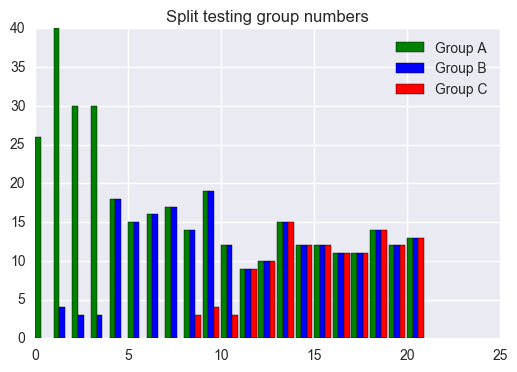

In [19]:
split=pd.DataFrame(data.groupby('day')['arm'].value_counts())
split=split.rename(columns={"arm":"number"})
split=split.reset_index()
split_a=split[split["arm"]=='A']
split_b=split[split["arm"]=='B']
split_c=split[split["arm"]=='C']
plt.bar(split_a["day"], split_a["number"], color="green", width=0.3, label="Group A")
plt.bar(split_b["day"]+0.3, split_b["number"], color="blue", width=0.3,  label="Group B")
plt.bar(split_c["day"]+0.6, split_c["number"], color="red", width=0.3,  label="Group C")
plt.legend(loc="upper right")
plt.title("Split testing group numbers")
plt.show()

**Check:** how many arms are there?

### 1.2 Look at mean conversion rate overall and by arm

In [21]:
print(data["converted"].mean())
print(data.groupby('arm')['converted'].agg(np.mean))

0.175172413793
arm
A    0.185393
B    0.116667
C    0.255814
Name: converted, dtype: float64


In [22]:
print(data["converted"].std())
print(data.groupby('arm')['converted'].agg(np.std))

0.380376927498
arm
A    0.389163
B    0.321694
C    0.438019
Name: converted, dtype: float64


### 1.3 Look at overall conversion rate differences along age, gender, and fitness

In [23]:
data.groupby('age')['converted'].agg(np.mean)

age
20-30    0.253112
30-40    0.155738
40-50    0.116667
Name: converted, dtype: float64

In [24]:
data.groupby('gender')['converted'].agg(np.mean)

gender
female    0.206897
male      0.145889
Name: converted, dtype: float64

In [25]:
data.groupby('fitness')['converted'].agg(np.mean)

fitness
-5.0    0.055556
-4.0    0.026316
-3.0    0.073171
-2.0    0.148649
-1.0    0.086957
 0.0    0.179487
 1.0    0.161290
 2.0    0.171053
 3.0    0.276923
 4.0    0.391892
 5.0    0.484848
Name: converted, dtype: float64

In [8]:
data["arm"].value_counts()

A    356
B    240
C    129
Name: arm, dtype: int64

## 2. Model conversion rates through day 5 with `pymc3`

We will start by just modeling the conversion rate distributions for arms A and B through to day 5. By day 5, arm C has not been introduced yet and so there are still just 2 arms.

### 2.1 Subset the data to the first 5 days

In [51]:
current = data[data.day < 5]
print(current.shape, current.arm.unique())

(172, 7) ['A' 'B']


In [52]:
print(current.groupby('arm')['converted'].agg(np.sum))

arm
A    26
B     3
Name: converted, dtype: int64


### 2.2 Set up a `pymc3` model and uniform priors for the probabilities of conversion for arms A and B

Recall that `pymc3` uses the `with ...` syntax for defining models. The first step in setting up a new model is to define the model as the "context" like so:

>```python
day5_model=pm.Model()
with day5_model:
    #
```

We are going to model the _probability distributions for conversion rates for arms A and B._ As always with Bayesian statistics, we need to define prior distributions for our belief about these probabilities/rates of conversion per arm. Let's say we have no belief whatsoever about rates, and so we will set an uninformative, flat prior over probabilities from 0 to 1 for both arms. This is equivalent to saying that we believe all conversion rates to be equally likely for both arms. This prior will then not have an influence on the posterior outcome (but we still define it).

The syntax for setting up this flat prior is:

>```python
arm_A_prior = pm.Uniform('A_prior', lower=0, upper=1)
```

Set up the priors for both arms inside the `with ...` model block.

In [53]:
with pm.Model() as day5_unpooled:
    
    A_p = pm.Uniform('A_prob', lower=0, upper=1)
    B_p = pm.Uniform('B_prob', lower=0, upper=1)

Applied interval-transform to A_prob and added transformed A_prob_interval_ to model.
Applied interval-transform to B_prob and added transformed B_prob_interval_ to model.


### 3.2 Set up `pm.Bernoulli` distributions to model conversions for arms A and B

Now that you've initialised your model, your `with` statements will be

>```python
with day5_model:
    #
```

Be careful not to re-define the model with `pm.Model()` or it will wipe the uniform priors you set before! We are now going to set up the "likelihood" portion of the model. This is going to model the $P(data\;|\;\theta)$ part of Bayes theorem. Our conversions are represented by a vector of 1s and 0s denoting whether or not the user converted or not. This is hence a "Bernoulli" process and pymc3 has an approprite function to handle it:

>```python
A_conversions = pm.Bernoulli('A_conversions', p=arm_A_prior, observed=arm_A_conversions)
```

`p=` (probability of success) is set to the prior for the arm that you defined in the last section. `observed=` should be set to the `converted` values for that arm specifically in the data. By giving it an `observed` parameter, we are telling pymc3 that we want this to evaluate the likelihood of our data (the conversions) against models represented by the `p=` probability argument. We assign `p=` to be our prior belief about conversion rates in the first instance for that arm because we then want to update this belief (convert to posterior) based on the conversion data we have observed for that arm.

In [54]:
with day5_unpooled:
    
    A = pm.Bernoulli('A', p=A_p, observed=current[current["arm"] == "A"]["converted"].values)
    B = pm.Bernoulli('B', p=B_p, observed=current[current["arm"] == "B"]["converted"].values) 

### 3.3 Fit the model using MCMC

Now that we've set up the prior distributions and likelihoods, we can actually fit the model. Below is code that will run MCMC on the model we have parameterised:

>```python
with day5_model:
    start = pm.find_MAP()
    trace = pm.sample(10000, start=start)
```

Again you use the context `with day5_model:` to run code for your model.

`start = pm.find_MAP()` will try to find a good starting point for the MCMC sampling process. This means that your model will converge on the "likely" area much faster (though it makes the fitting slower initially). We skipped over this when we looked at pymc3 previously and stated you would have to input some starting point randomly. This function is an attempt to find a sensible starting point that is likely to be close to the true value (it stands for maximum aposteriori estimate).

`trace = pm.sample(10000, start=start)` uses the sampling method in pymc3 to perform 10,000 MCMC sampling iterations. This will automatically assign the NUTS sampler for you, which is more advanced but actually slower than the Metropolis-Hastings sampling we covered in class. The dataset is small so the speed shouldn't be so noticeable. You can optionally set the sampler to Metropolis with the keyword in the `pm.sample(step=pm.Metropolis())` When this completes, the `trace` variable now contains the posterior samples for the distributions we specified while constructing the model.

>```python
# We defined our arm A prior distribution to be uniform and named it 'arm_A_prior'. 
# The pm.sample() procedure converted this into our posterior belief for the rate
# of conversions in arm A. You can access these posterior samples using the name
# you gave the variable when you created it:
#
trace['arm_A_prior']
#
# this will be a vector of values that are different potential rates of conversion
# for arm A. A histogram of these rates defines, roughly, the posterior probability
# distribution for the arm A rates after we consider the data we have collected.
```

In [55]:
with day5_unpooled:
    # obtain starting values via MAP
    start=pm.find_MAP()
    # use Metropolis
    step=pm.Metropolis()
    trace = pm.sample(10000, start=start, step=step)

100%|██████████| 10000/10000 [00:04<00:00, 2111.43it/s]


### 3.4 Use `pm.traceplot` to look at your posterior distributions

The `pm.traceplot()` function accepts the trace variable from your model sampling and will plot out the posterior distributions for all of the distributions you defined. Recall it is best practice to get rid of a portion of the first samples; after some iterations the MCMC sampling procedure will make its way to the most likely region.

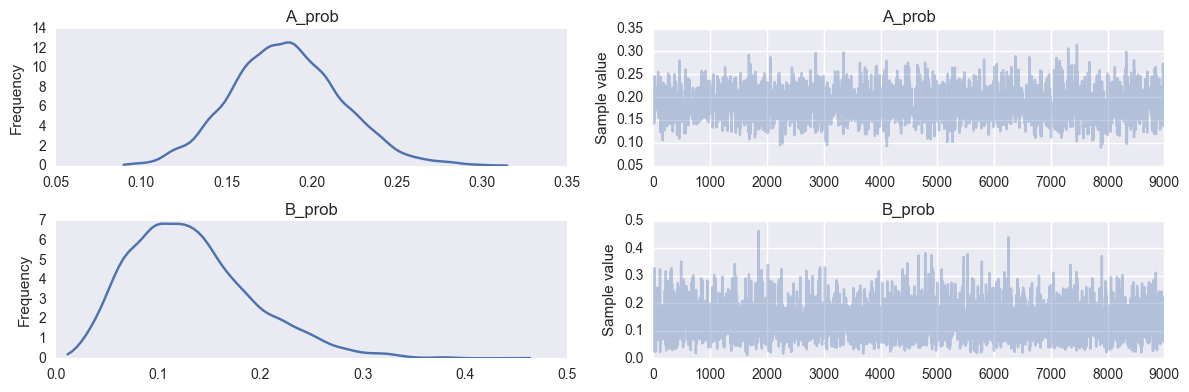

In [56]:
pm.traceplot(trace[1000:])
plt.show()

**Check:** what are the left and right hand side plots return by the traceplot function telling you?

### 3.5 Write a function to plot your data distributions using `sns.distplot`

Your function should:

1. Accept the trace values to plot as an argument.
- Accept a list of names to label each trace.
- Plot the traces on the same axis using `sns.distplot(...)` with `kde=True` in different colors for each distribution.
- Have a legend that labels the distributions.

Say you had defined a prior

>```python
A_p = pm.Uniform('A_prob', lower=0, upper=1)
```

and then fit the model using `pm.sample(...)` like so

>```python
with model:
    start = pm.find_MAP()
    trace = pm.sample(10000, start=start)
```

The `trace` variable now contains the samples of your posterior distribution for `A_prob` (and every other prior distribution that was converted to a posterior during the sampling process). You can access the values like so:

>```python
A_prob_trace_values = trace['A_prob']
```

You'll typically want to discard a portion of the starting MCMC samples as the process may still be searching for the "likely" area during that start-up period:

>```python
A_prob_trace_values = trace[1000:]['A_prob']
```



You can pass an existing axis as a keyword argument into the function: `sns.distplot(..., ax=ax)` and it will plot the distribution on the existing axis. The distplot function also accepts a label argument: `sns.distplot(..., label=label)`. To show the legend, you can use `ax.legend(loc='upper right')` or whatever location you think looks best.

In [57]:
def plot_betas(beta_traces, beta_names, colors=['steelblue','darkred','goldenrod']):
    fig, ax = plt.subplots(figsize=(9,5))
    for i, bn in enumerate(beta_names):
        ax = sns.distplot(beta_traces[i], kde=True, color=colors[i], label=bn)
    ax.legend(loc='upper right')
    plt.show()

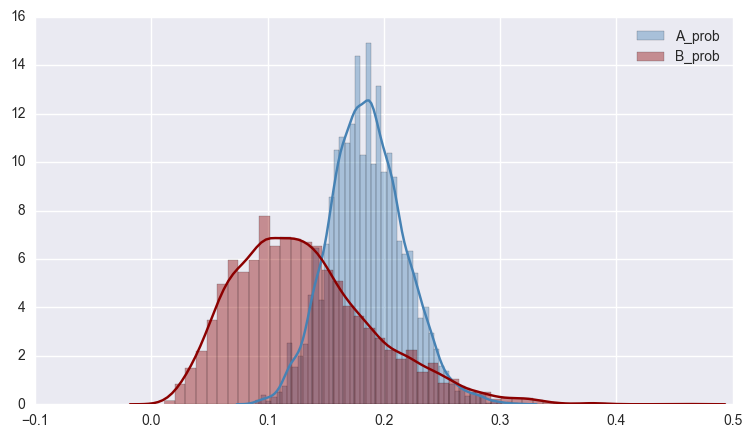

In [58]:
plot_betas([trace[1000:]['A_prob'], trace[1000:]['B_prob']], ['A_prob','B_prob'])

### 3.6 Re-build the same model, but add a `pm.Deterministic` variable that calculates the difference between A and B conversion rates

For example, if I have two priors

>```python
A_p = pm.Uniform('A_prob', lower=0, upper=1)
B_p = pm.Uniform('B_prob', lower=0, upper=1)
```

I can set up a "deterministic" variable that is some specific calculation I want to do on each iteration of the MCMC sampling process

>```python
AvB = pm.Deterministic('AvB', A_p - B_p)
```

This will be a distribution with the differences between `A_p` and `A_b` on each sampling iteration; a posterior of the differences. Recreate the model we built and ran above, but add the determinisic variable in the model definition before you do the sampling procedure. Recall that this allows us to describe the difference between the two groups. So in this case, you should reinitialise with `pm.Model()` and rebuild the model.

In [65]:
with pm.Model() as day5_unpooled:
    
    A_p = pm.Uniform('A_prob', lower=0, upper=1)
    B_p = pm.Uniform('B_prob', lower=0, upper=1)
    
    A = pm.Bernoulli('A', p=A_p, observed=current[current.arm == "A"].converted.values)
    B = pm.Bernoulli('B', p=B_p, observed=current[current.arm == "B"].converted.values)
    
    AvB = pm.Deterministic('AvB', A_p - B_p)
    
    start = pm.find_MAP()
    trace = pm.sample(10000, start=start)

Applied interval-transform to A_prob and added transformed A_prob_interval_ to model.
Applied interval-transform to B_prob and added transformed B_prob_interval_ to model.
Assigned NUTS to A_prob_interval_
Assigned NUTS to B_prob_interval_
100%|██████████| 10000/10000 [00:05<00:00, 1705.18it/s]


### 3.7 Plot the posterior of the differences between arms using `pm.plot_posterior`

You can specify in `varnames` which posterior distribution you want to plot from your trace using the function, like so:

>```python
pm.plot_posterior(trace[5000:], varnames=['AvB'], color='#87ceeb', ref_val=0.)
```

In the above example, `ref_val=0` will plot a bar at 0 on the x-axis, which is useful for visualizing the proportion of the distribution of differences does not contain 0.

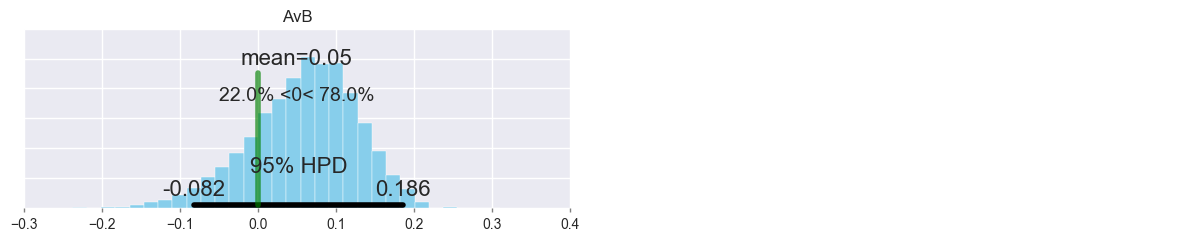

In [62]:
pm.plot_posterior(trace[1000:], varnames=['AvB'], color='#87ceeb', ref_val=0)
plt.show()

### 3.8 Based on the posterior distribution of differences, what can you say about the split test arms? What is the probability one is better than another?

Take a look back at previous lessons/labs if you are unsure of the interpretation. Also try Chapter 2 of _Bayesian Methods for Hackers_ [here](http://nbviewer.jupyter.org/github/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/tree/master/)

In [21]:
# with a ~78% confidence group A conversion is higher than group B
# so the question is just how much confidence does the business want that
# the two are distinct? if it wants more (maybe 95%) it can run the test for longer...

In [68]:
print("Probability arm A is BETTER than arm B: %.3f" % np.mean(trace[1000:]["AvB"] > 0))

Probability site A is BETTER than site B: 0.796


## 4. Perform the same analysis through day 8

We are going to do the same model-buidling process we went through above, but now on the data through day 8. **Subset to just the first 8 days:**

In [41]:
current = data[data.day < 8]
print(current.shape, current["arm"].unique())

(268, 7) ['A' 'B']


### 4.1 Build and fit the day 8 model

This will be the same specification as your model for day 5. Keep the deterministic distribution that models the differences between arm A's rate and arm B's rate that we added in the second half of question 3.

In [42]:
with pm.Model() as day8_unpooled:
    
    A_p = pm.Uniform('A_prob', lower=0, upper=1)
    B_p = pm.Uniform('B_prob', lower=0, upper=1)
    
    A = pm.Bernoulli('A', p=A_p, observed=current[current.arm == "A"].converted.values)
    B = pm.Bernoulli('B', p=B_p, observed=current[current.arm == "B"].converted.values)
    
    AvB = pm.Deterministic('AvB', A_p - B_p)
    
    start = pm.find_MAP()
    trace = pm.sample(10000, start=start)

Applied interval-transform to A_prob and added transformed A_prob_interval_ to model.
Applied interval-transform to B_prob and added transformed B_prob_interval_ to model.
Assigned NUTS to A_prob_interval_
Assigned NUTS to B_prob_interval_
100%|██████████| 10000/10000 [00:05<00:00, 1760.83it/s]


### 4.2 Plot the traces with `pm.traceplot`

[]

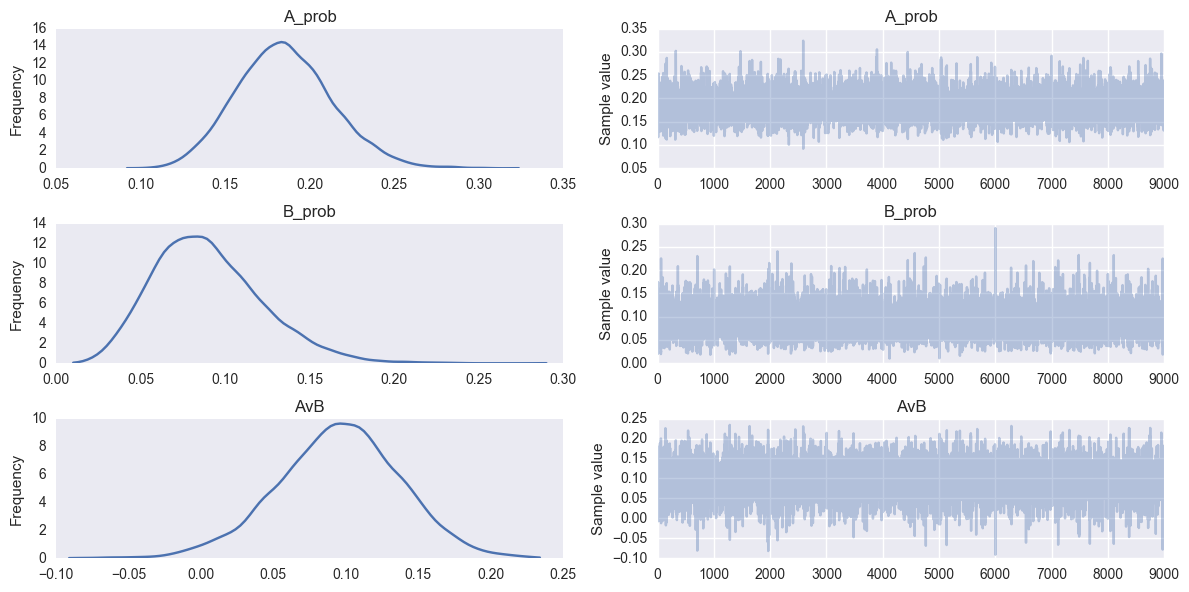

In [44]:
pm.traceplot(trace[1000:])
plt.plot()

### 4.3 Plot the posterior distributions for arms A and B with your custom function

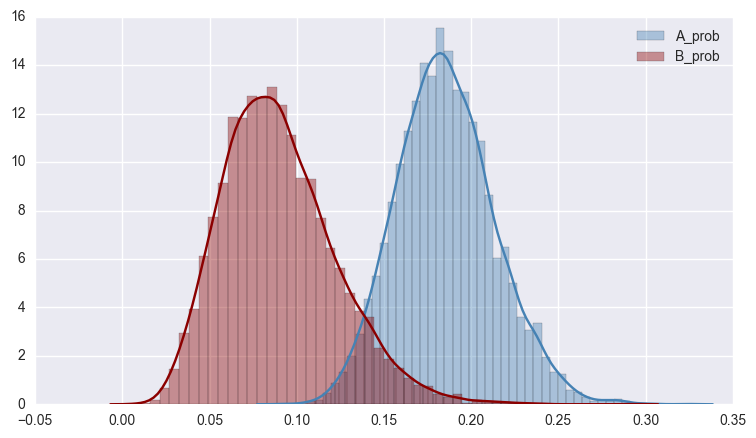

In [45]:
plot_betas([trace[2500:]['A_prob'], trace[2500:]['B_prob']], ['A_prob','B_prob'])

### 4.4 Plot the posterior distribution of differences between A and B with `pm.plot_posterior`

array([<matplotlib.axes._subplots.AxesSubplot object at 0x12e0c1350>], dtype=object)

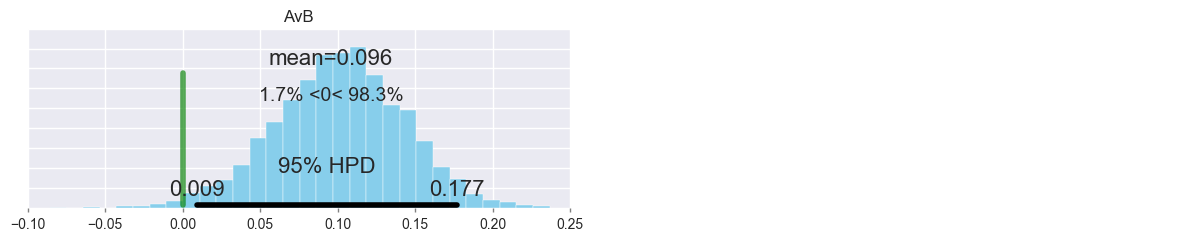

In [46]:
pm.plot_posterior(trace[2500:], varnames=['AvB'], color='#87ceeb', ref_val=0.)

### 4.5 Again based on the posterior distribution of differences, what can you say about the split test arms now?


In [ ]:
# Now there is a 98% confidence that group A has a higher conversion than group B. Hooray!

# [Bonus] dealing with more than two arms

This introduces a new concept of hierarchical modelling for multiple arm tests.

## 5. Perform the same type of analysis through day 11

There are now three arms: A, B, and C.

### 5.1 Build and fit the model

You will now need to reinitialise the model again and add in capability for handling the third arm. You should also now calculate 3 "deterministic" variables that look at differences between the three arms:

- `A` vs. `B`
- `A` vs. `C`
- `B` vs. `C`

In [47]:
current = data[data.day < 11]
print(current.shape, current.arm.unique())

(368, 7) ['A' 'B' 'C']


In [48]:
with pm.Model() as day11_unpooled:
    
    A_p = pm.Uniform('A_prob', lower=0, upper=1)
    B_p = pm.Uniform('B_prob', lower=0, upper=1)
    C_p = pm.Uniform('C_prob', lower=0, upper=1)
    
    A = pm.Bernoulli('A', p=A_p, observed=current[current.arm == "A"].converted.values)
    B = pm.Bernoulli('B', p=B_p, observed=current[current.arm == "B"].converted.values)
    C = pm.Bernoulli('C', p=C_p, observed=current[current.arm == "C"].converted.values)
    
    AvB = pm.Deterministic('AvB', A_p - B_p)
    AvC = pm.Deterministic('AvC', A_p - C_p)
    BvC = pm.Deterministic('BvC', B_p - C_p)
    
    start = pm.find_MAP()
    trace = pm.sample(10000, start=start)

Applied interval-transform to A_prob and added transformed A_prob_interval_ to model.
Applied interval-transform to B_prob and added transformed B_prob_interval_ to model.
Applied interval-transform to C_prob and added transformed C_prob_interval_ to model.
Assigned NUTS to A_prob_interval_
Assigned NUTS to B_prob_interval_
Assigned NUTS to C_prob_interval_
100%|██████████| 10000/10000 [00:08<00:00, 1242.79it/s]


### 5.2 Plot the distributions for the arms using your custom function

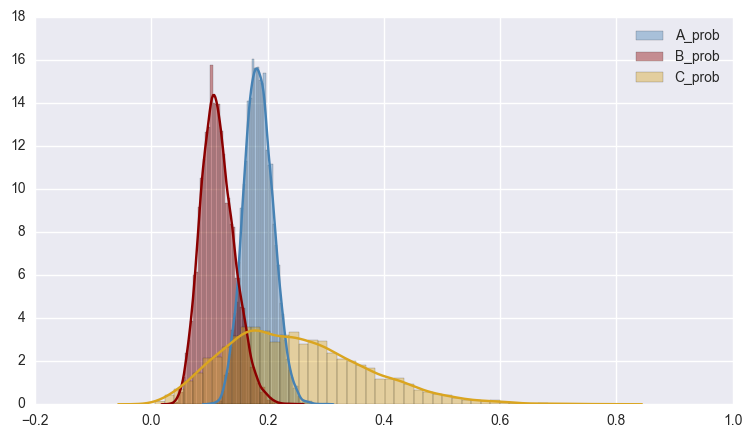

In [49]:
plot_betas([trace[2500:]['A_prob'], 
            trace[2500:]['B_prob'],
            trace[2500:]['C_prob']],
           ['A_prob','B_prob','C_prob'])

### 5.3 Plot the three difference measure posterior distributions using `pm.plot_posterior`

[]

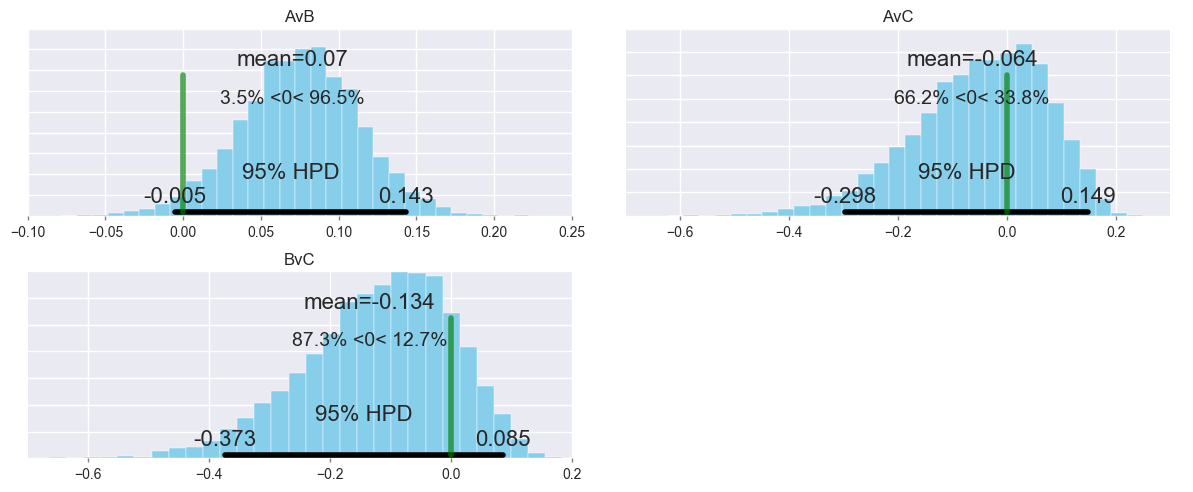

In [50]:
pm.plot_posterior(trace[2500:], varnames=['AvB','AvC','BvC'], color='#87ceeb', ref_val=0.)
plt.plot()

## 6. Perform a hierarchical split test analysis for data through to day 11

The problem with multiple comparisons is that if we take a standard AvB approach for every case we could overestimate the significance of differences. Thus far we have been constructing our models as **unpooled** models. This means that we are modeling the effect of arms A, B, and C on conversion rate independently. On the opposite end of this spectrum we would have a **pooled** model, where we would instead model A, B, and C with a single parameter. To do this, we would have to code the arms as numbers and then fit a single coefficient on them.

In this case we can build a **partial pooling** model. In partial pooling, each arm gets its own effect like in the unpooled model, but they _share a prior for how they are parameterised_. This means that if we have an arm with very few observations like arm C, our estimation for the conversion rate of arm C will be a combination of the overall conversion rate across arms and the specific conversion rate for just arm C's data. The less data any arm has, the more its estimation will shrink towards the overall conversion rate. See [here](http://twiecki.github.io/blog/2014/03/17/bayesian-glms-3/) for another detailed overview of hierarchical modeling and partial pooling with pymc3. [This](http://sl8r000.github.io/ab_testing_statistics/use_a_hierarchical_model/) also has a good discussion.


### 6.1 Build and fit the hierarchical model

Now that we are building a hierarchical model, a few things are going to change. 

**1. Set up distributions for "group level" alpha and beta.**

We need to have a prior for the "overall" or "across-arm" alpha and beta values that will define their Beta distributions. The prior/posterior for each arm is going to be modeled with a Beta distribution, which is a handy distribution for modelling probability of occurances or rates (we saw this before - when coupled to a binomial case then the posterior of a beta prior is also a beta). The beta distribution, as you may recall, is parameterised by an alpha and beta parameter:

    alpha: successes + 1
    beta: failures + 1
    
Where successes will be conversions and failures will be non-conversions. Arm A, for example, can be set up in pymc3 like:

>```python
A_prior = pm.Beta('A_prior', alpha=?, beta=?)
```

As you can see, question marks have beeb placed in the alpha and beta keyword assignments. If we set alpha=1 and beta=1, this would be a uniform prior for arm A, like we were doing before. We could set alpha and beta as higher values and have a stronger prior belief about conversions. But what we need for our hierarchical model is that the three priors for arms A, B, and C _share_ a prior belief about what alpha and beta should be. So we want something like

>```python
A_prior = pm.Beta('A_prior', alpha=group_alpha, beta=group_beta)
B_prior = pm.Beta('B_prior', alpha=group_alpha, beta=group_beta)
```

Where `group_alpha` and `group_beta` are themselves prior distributions for likely values of alpha and beta. By having all the A, B, and C arm priors share the same alpha and beta prior beliefs, we tie them together and achieve partial pooling. For example, imagine that we have very few observations of successes and failures (like with arm C). Because there are so few datapoints, the prior will not change much from the distribution defined by `group_alpha` and `group_beta`.

On the other hand, if we have a lot of observations like with arm A, the quantity of data will have a strong effect on the prior-to-posterior conversion and so our posterior will be more defined by the data tahn by `group_alpha` and `group_beta`. This means that with little data, the rate distribution for an arm shrinks towards the overall group conversion rate. To set up a group alpha and beta prior, we can use the `pm.Gamma()` distribution. The gamma distribution is strictly positive and in pymc we can define it with a mean and standard deviation. For the group level alpha, for example:

>```python
group_alpha = pm.Gamma('group_alpha', mu=10, sd=100)
```

The high standard deviation means that larger values are close in likelihood to smaller values, which is good since we want this to be fairly uninformative.


#### Construct the hierarchical model

Given all the information above, try to build the hierarchical model with group level alpha/beta priors and arm prior distributions defined by `pm.Beta` distributions that accept the group alpha and beta values as parameters. The rest of the model structure should essentially be the same as what you've been doing so far.

In [31]:
with pm.Model() as day11_partial_pooling:
    
    hyper_alpha = pm.Gamma('hyper_alpha', mu=10, sd=100)
    hyper_beta = pm.Gamma('hyper_beta', mu=10, sd=100)
    
    A_prior = pm.Beta('A_prob', alpha=hyper_alpha, beta=hyper_beta)
    B_prior = pm.Beta('B_prob', alpha=hyper_alpha, beta=hyper_beta)
    C_prior = pm.Beta('C_prob', alpha=hyper_alpha, beta=hyper_beta)
    
    A = pm.Bernoulli('A', p=A_prior, 
                     observed=current[current.arm == "A"].converted.values)
    B = pm.Bernoulli('B', p=B_prior, 
                     observed=current[current.arm == "B"].converted.values)
    C = pm.Bernoulli('C', p=C_prior, 
                     observed=current[current.arm == "C"].converted.values)
    
    AvB = pm.Deterministic('AvB', A_prior - B_prior)
    AvC = pm.Deterministic('AvC', A_prior - C_prior)
    BvC = pm.Deterministic('BvC', B_prior - C_prior)
    
    start = pm.find_MAP()
    trace_partial = pm.sample(10000, start=start)

Applied log-transform to hyper_alpha and added transformed hyper_alpha_log_ to model.
Applied log-transform to hyper_beta and added transformed hyper_beta_log_ to model.
Applied logodds-transform to A_prob and added transformed A_prob_logodds_ to model.
Applied logodds-transform to B_prob and added transformed B_prob_logodds_ to model.
Applied logodds-transform to C_prob and added transformed C_prob_logodds_ to model.
Assigned NUTS to hyper_alpha_log_
Assigned NUTS to hyper_beta_log_
Assigned NUTS to A_prob_logodds_
Assigned NUTS to B_prob_logodds_
Assigned NUTS to C_prob_logodds_
 [-----------------100%-----------------] 10000 of 10000 complete in 48.3 sec

---

### 6.2 Plot the arm conversion rate distributions from your hierarchical model

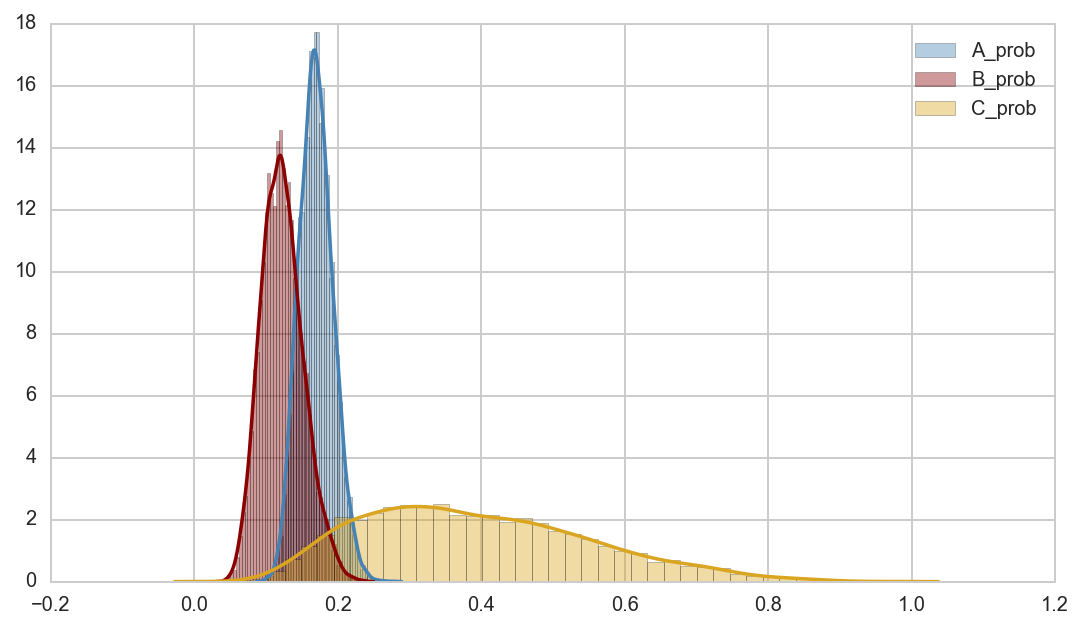

In [32]:
plot_betas([trace_partial[2500:]['A_prob'], 
            trace_partial[2500:]['B_prob'],
            trace_partial[2500:]['C_prob']],
           ['A_prob','B_prob','C_prob'])

---

### 6.3 Plot the distribution for arm C from the non-hierarchical (unpooled) model vs the hierarchical (pooled) model

NOTE: if the "trace" variable is named the same thing for the hierarchical model and unpooled model, then it probably overwrote the original trace. 

Make sure that the trace variable for your original and hierarchical models are named different things before doing this section (you may have to re-run the model, sorry!).

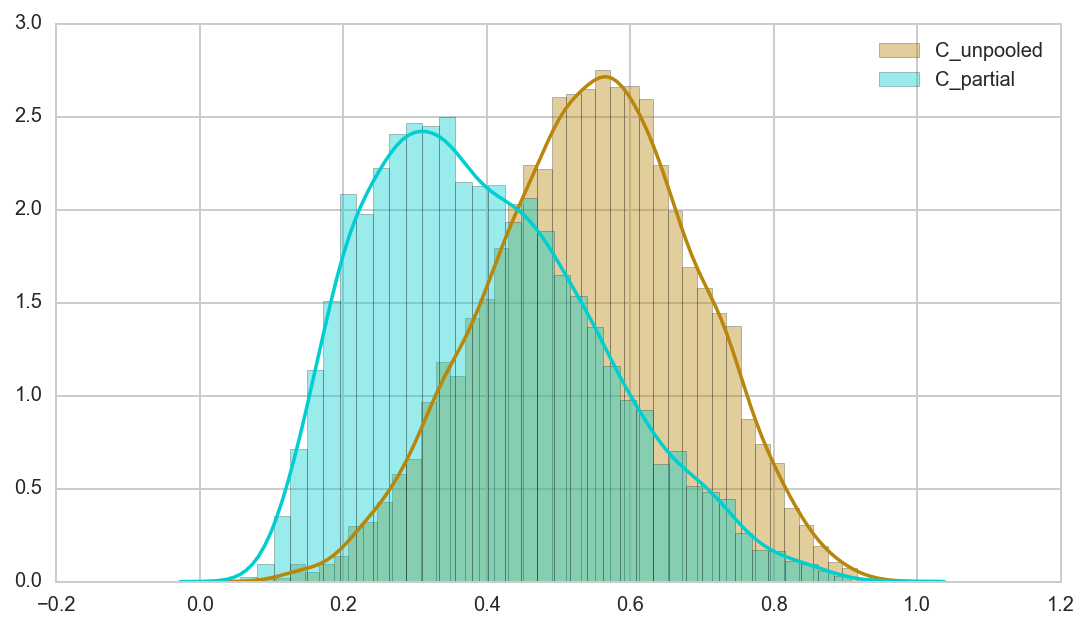

In [33]:
plot_betas([trace[2500:]['C_prob'], 
            trace_partial[2500:]['C_prob']],
           ['C_unpooled','C_partial'], 
           colors=['darkgoldenrod','darkturquoise'])

---

### 6.4 Plot the posterior difference variables with `pm.plot_posterior`

array([<matplotlib.axes._subplots.AxesSubplot object at 0x155879390>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x15196d050>], dtype=object)

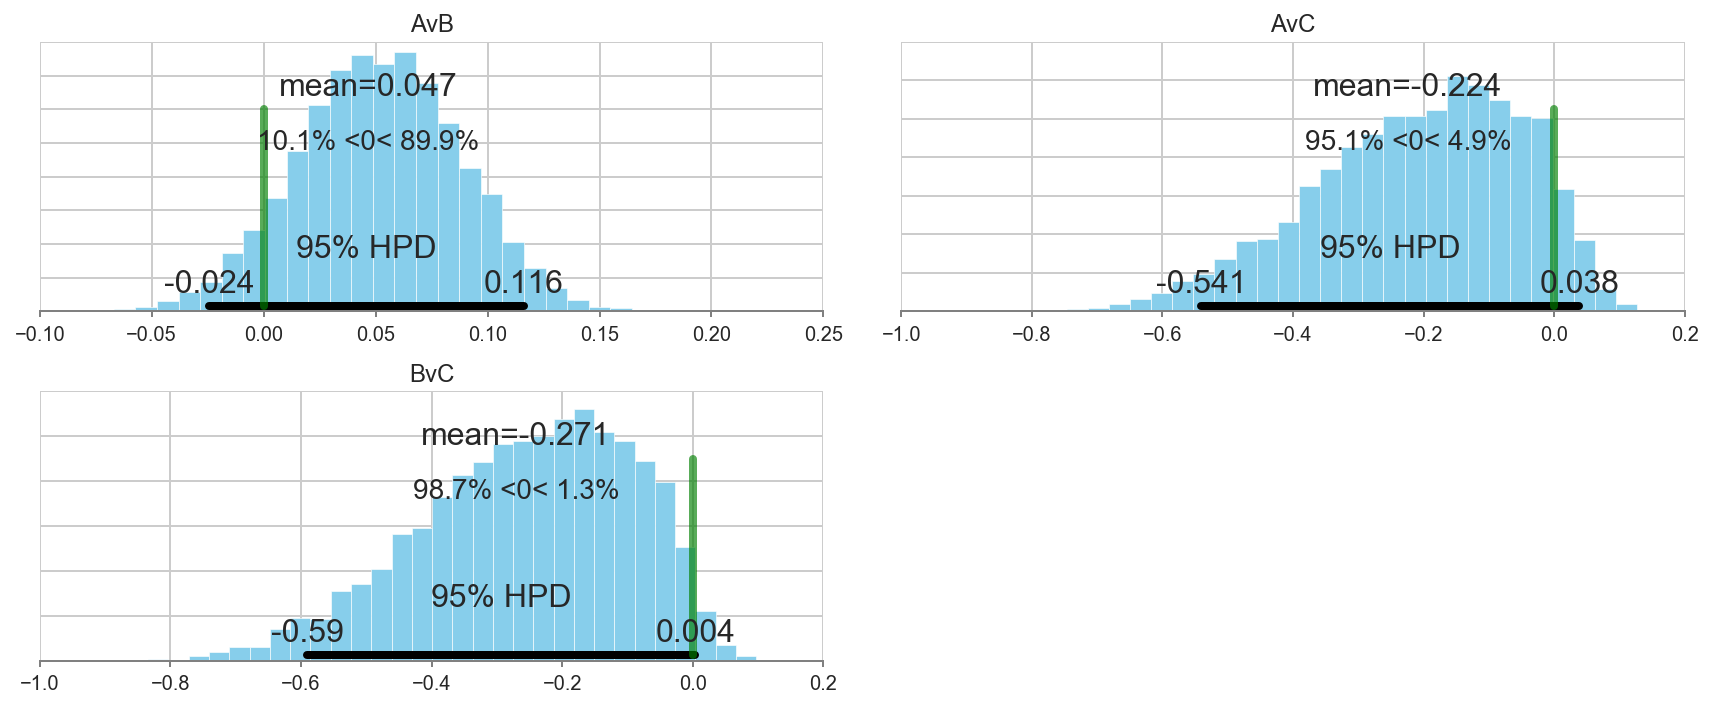

In [34]:
pm.plot_posterior(trace_partial[2500:], varnames=['AvB','AvC','BvC'], color='#87ceeb', ref_val=0.)

---

## 7. Make a hierarchical split test model for the whole dataset

Now do the same thing you just did above for the hierarchical model, but use the entire 21 days of data in the dataset.

---

### 7.1 Build the hierarchical model

In [35]:
with pm.Model() as day21_partial_pooling:
    
    hyper_alpha = pm.Gamma('hyper_alpha', mu=10, sd=100)
    hyper_beta = pm.Gamma('hyper_beta', mu=10, sd=100)
    
    A_prior = pm.Beta('A_prob', alpha=hyper_alpha, beta=hyper_beta)
    B_prior = pm.Beta('B_prob', alpha=hyper_alpha, beta=hyper_beta)
    C_prior = pm.Beta('C_prob', alpha=hyper_alpha, beta=hyper_beta)
    
    A = pm.Bernoulli('A', p=A_prior, 
                     observed=data[data.arm == "A"].converted.values)
    B = pm.Bernoulli('B', p=B_prior, 
                     observed=data[data.arm == "B"].converted.values)
    C = pm.Bernoulli('C', p=C_prior, 
                     observed=data[data.arm == "C"].converted.values)
    
    AvB = pm.Deterministic('AvB', A_prior - B_prior)
    AvC = pm.Deterministic('AvC', A_prior - C_prior)
    BvC = pm.Deterministic('BvC', B_prior - C_prior)
    
    start = pm.find_MAP()
    trace_partial = pm.sample(10000, start=start)

Applied log-transform to hyper_alpha and added transformed hyper_alpha_log_ to model.
Applied log-transform to hyper_beta and added transformed hyper_beta_log_ to model.
Applied logodds-transform to A_prob and added transformed A_prob_logodds_ to model.
Applied logodds-transform to B_prob and added transformed B_prob_logodds_ to model.
Applied logodds-transform to C_prob and added transformed C_prob_logodds_ to model.
Assigned NUTS to hyper_alpha_log_
Assigned NUTS to hyper_beta_log_
Assigned NUTS to A_prob_logodds_
Assigned NUTS to B_prob_logodds_
Assigned NUTS to C_prob_logodds_
 [-----------------100%-----------------] 10000 of 10000 complete in 35.0 sec

---

### 7.2 Plot the conversion rate distributions for arms

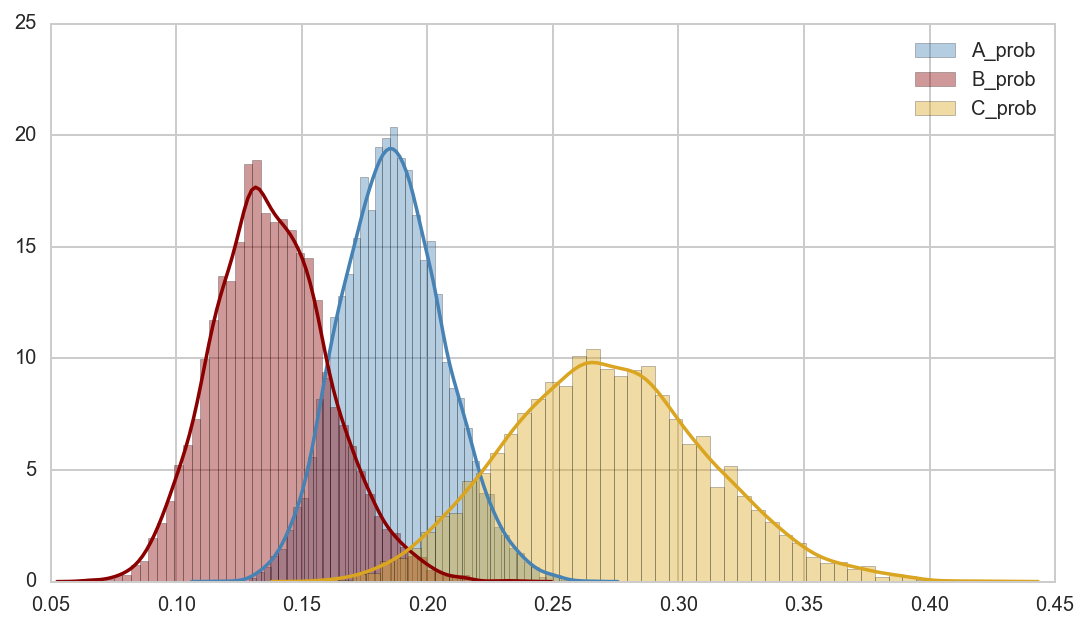

In [36]:
plot_betas([trace_partial[2500:]['A_prob'], 
            trace_partial[2500:]['B_prob'],
            trace_partial[2500:]['C_prob']],
           ['A_prob','B_prob','C_prob'])

---

### 7.3 Plot the posterior distributions for differences between arms

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1692c2210>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x15ff49850>], dtype=object)

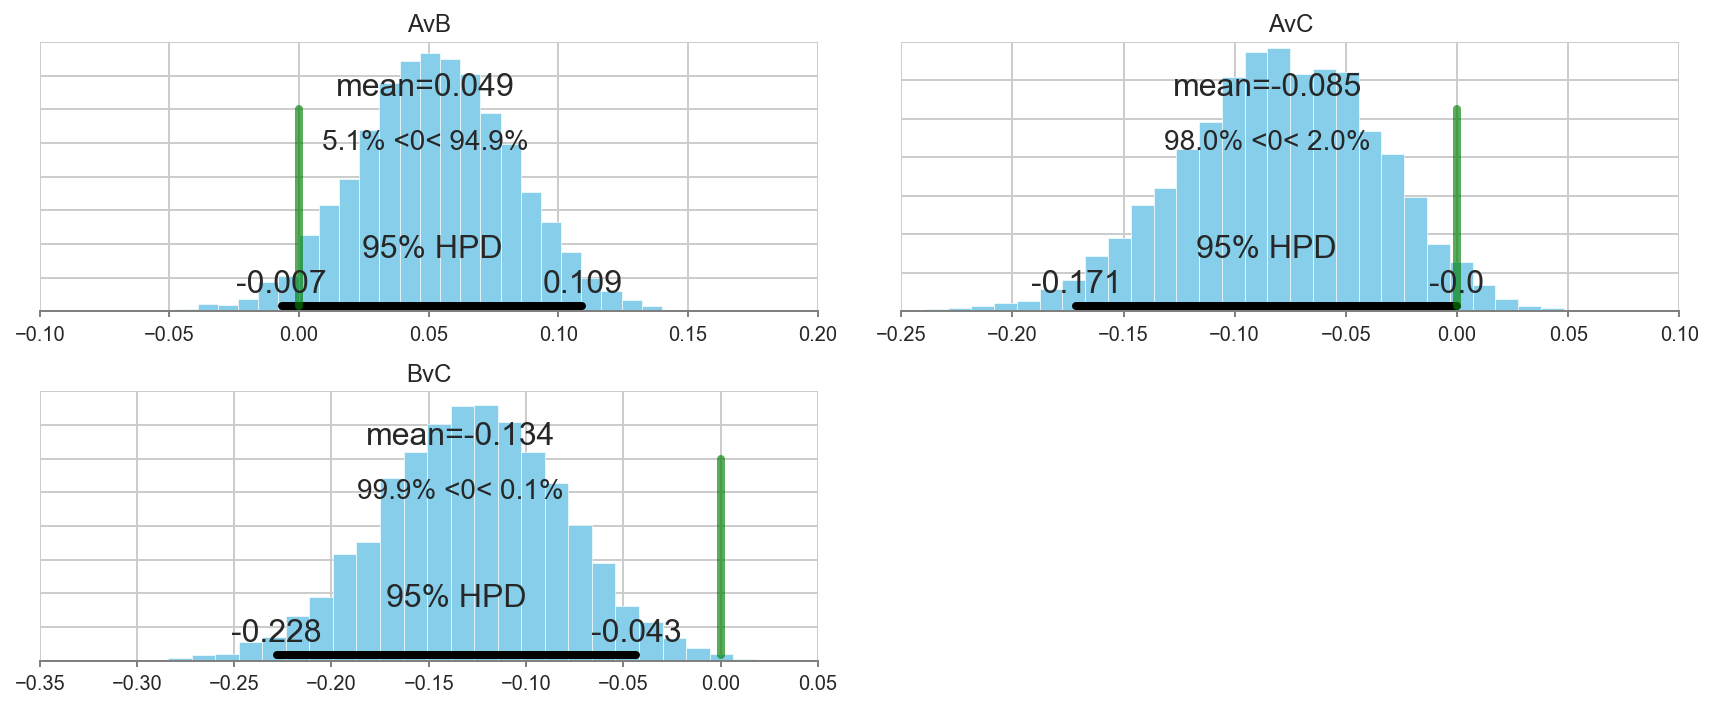

In [37]:
pm.plot_posterior(trace_partial[2500:], varnames=['AvB','AvC','BvC'], 
                  color='#87ceeb', ref_val=0.)